In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, fowlkes_mallows_score
from sklearn.feature_selection import mutual_info_classif

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import arff

In [2]:
# Dataset info
data, meta = arff.loadarff('dataset/iris.arff')
df = pd.DataFrame(data)
print(df.head())
print("\n")
print(df.info())
print("\n")
print(df.isnull().sum())
print("\n")
print("Unique values:", df['class'].unique())

   sepallength  sepalwidth  petallength  petalwidth           class
0          5.1         3.5          1.4         0.2  b'Iris-setosa'
1          4.9         3.0          1.4         0.2  b'Iris-setosa'
2          4.7         3.2          1.3         0.2  b'Iris-setosa'
3          4.6         3.1          1.5         0.2  b'Iris-setosa'
4          5.0         3.6          1.4         0.2  b'Iris-setosa'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
 4   class        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64


Unique values: [b'Iris-setosa' b'

In [3]:
# Data preprocessing
df.replace('?', np.nan, inplace=True)
df = df.dropna()

# Convert string into a proper format
df['class'] = df['class'].str.decode('utf-8')
print("Dataset shape after preprocessing: \n", df.shape)

Dataset shape after preprocessing: 
 (150, 5)


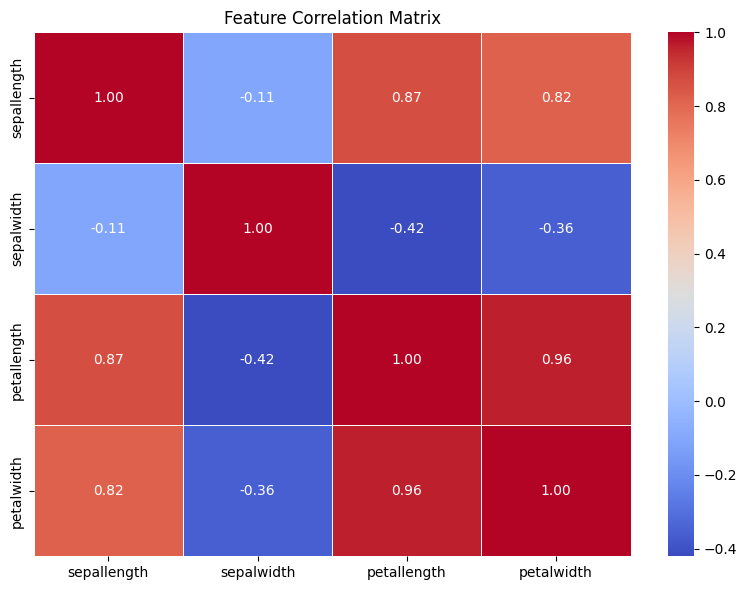

In [4]:
# Correlation Matrix
correlation_matrix = df.iloc[:, :-1].corr() 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [5]:
# Features and target
X = df.drop('class', axis=1)
y = df['class']

In [6]:
# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [8]:
# Perceptron - Initialize and train
perceptron = Perceptron(max_iter=1000, eta0=0.1, random_state=42)
perceptron.fit(X_train, y_train)
feature_names = df.columns[:-1] 
coef_df = pd.DataFrame(perceptron.coef_, columns=feature_names)
print(f"Importance of features: \n{coef_df}")

Importance of features: 
   sepallength  sepalwidth  petallength  petalwidth
0         0.30        0.79        -1.25       -0.52
1         1.25       -4.08        -0.05       -3.27
2        -2.76       -2.49         2.78        2.74


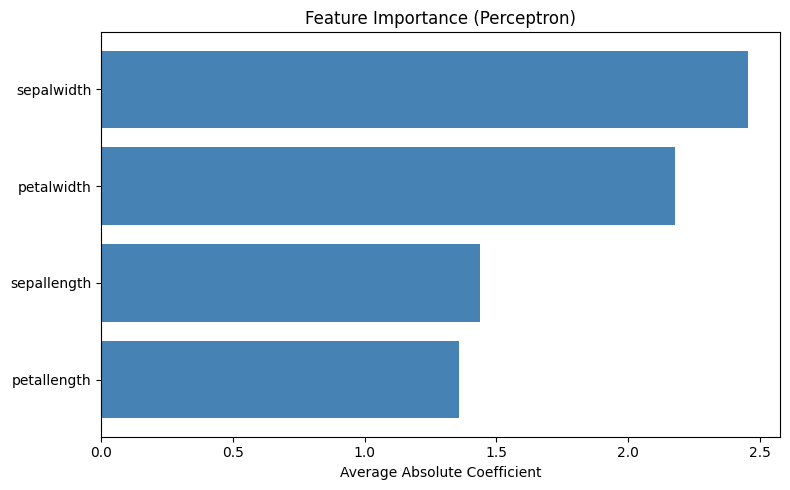

In [9]:
importance = np.abs(coef_df).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.title("Feature Importance (Perceptron)")
plt.xlabel("Average Absolute Coefficient")
plt.tight_layout()
plt.show()

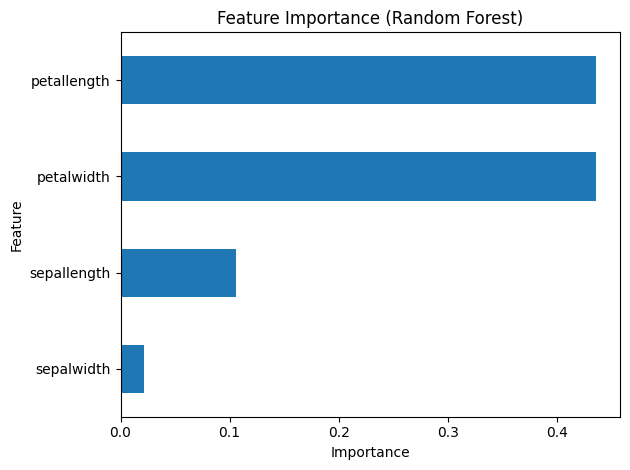

In [10]:
# Extracting important features - Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=feature_names)
feature_importance.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

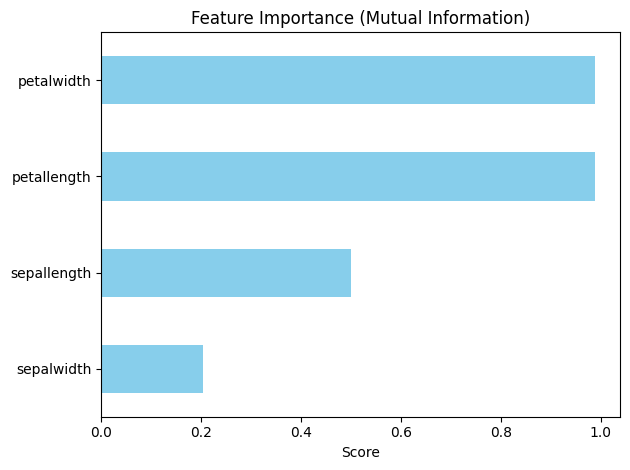

In [11]:
# Extracting important features - Mutual Information
mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=feature_names)
mi_series.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title("Feature Importance (Mutual Information)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [12]:
# Create data subsets with fewer features
X_widths = df[['sepalwidth', 'petalwidth']]
X_petals = df[['petalwidth', 'petallength']]
X_sepals = df[['petalwidth', 'sepallength', 'sepalwidth']]

In [13]:
# Splitting the subsets
X_widths_train, X_widths_test, y_widths_train, y_widths_test = train_test_split(X_widths, y_encoded, test_size=0.2, random_state=42)
X_petals_train, X_petals_test, y_petals_train, y_petals_test = train_test_split(X_petals, y_encoded, test_size=0.2, random_state=42)
X_sepals_train, X_sepals_test, y_sepals_train, y_sepals_test = train_test_split(X_sepals, y_encoded, test_size=0.2, random_state=42)

In [14]:
# Function to get perceptron results
def perceptron_results(X_train, X_test, y_train, y_test):
    perceptron = Perceptron(max_iter=1000, eta0=0.1, random_state=42)
    perceptron.fit(X_train, y_train)
    y_pred = perceptron.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=True)
    print(f"Perceptron Accuracy: {accuracy:.4f}\n")
    print("Classification Report:\n", report)
    cm = confusion_matrix(y_test, y_pred)
    labels = label_encoder.classes_.astype(str)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Perceptron - Confusion Matrix')
    plt.tight_layout()
    plt.show()
    return y_pred

Perceptron Accuracy: 0.3667

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.34      1.00      0.51        10
Iris-versicolor       1.00      0.00      0.00         9
 Iris-virginica       1.00      0.09      0.17        11

       accuracy                           0.37        30
      macro avg       0.78      0.36      0.23        30
   weighted avg       0.78      0.37      0.23        30



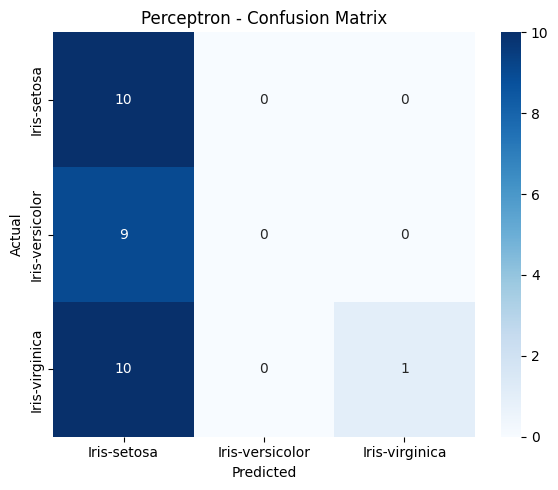

In [15]:
# Perceptron - Results (All classes)
y_pred = perceptron_results(X_test=X_test, X_train=X_train, y_train=y_train, y_test=y_test)

Perceptron Accuracy: 0.5333

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      0.60      0.75        10
Iris-versicolor       0.39      1.00      0.56         9
 Iris-virginica       1.00      0.09      0.17        11

       accuracy                           0.53        30
      macro avg       0.80      0.56      0.49        30
   weighted avg       0.82      0.53      0.48        30



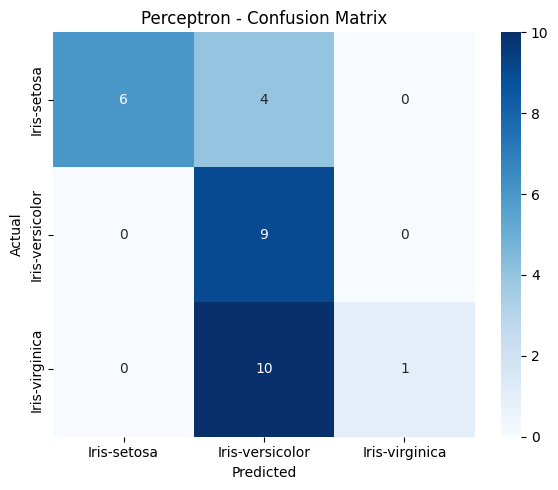

In [16]:
# Perceptron - Results (Widths only)
y_widths = perceptron_results(X_train=X_widths_train,X_test=X_widths_test, y_train=y_widths_train ,y_test=y_widths_test)

Perceptron Accuracy: 0.5333

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.48      1.00      0.65        10
Iris-versicolor       0.50      0.33      0.40         9
 Iris-virginica       1.00      0.27      0.43        11

       accuracy                           0.53        30
      macro avg       0.66      0.54      0.49        30
   weighted avg       0.68      0.53      0.49        30



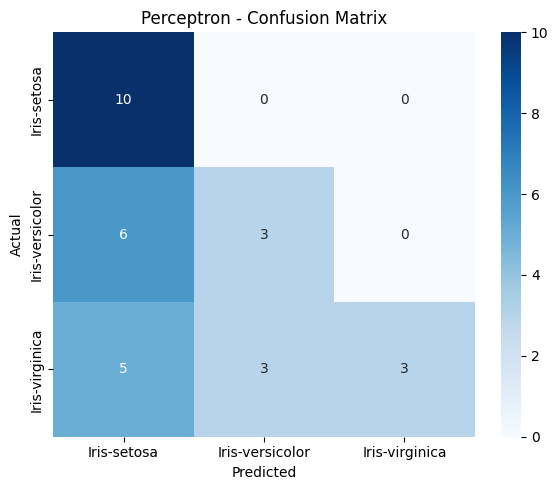

In [17]:
# Perceptron - Results (Petal width/length only)
y_petals = perceptron_results(X_train=X_petals_train,X_test=X_petals_test, y_train=y_petals_train ,y_test=y_petals_test)

Perceptron Accuracy: 0.9333

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.83      1.00      0.91        10
Iris-versicolor       1.00      0.78      0.88         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



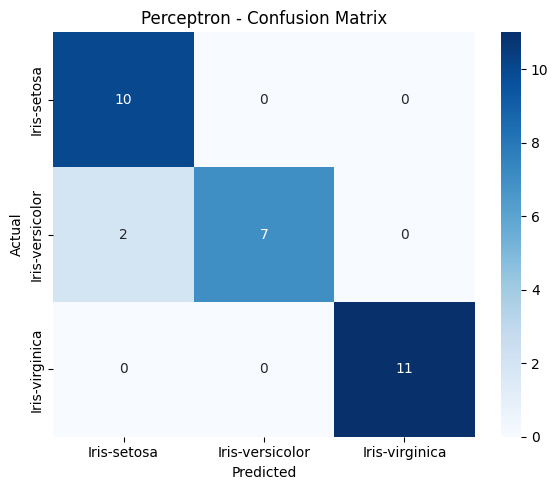

In [18]:
# Perceptron - Results (Sepals + petal width)
y_sepals = perceptron_results(X_train=X_sepals_train,X_test=X_sepals_test, y_train=y_sepals_train,y_test=y_sepals_test)

C:\Users\PC\AppData\Local\Temp\ipykernel_15088\3053990808.py:11: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  plt.legend(handles=scatter.legend_elements()[0], labels=labels.tolist())


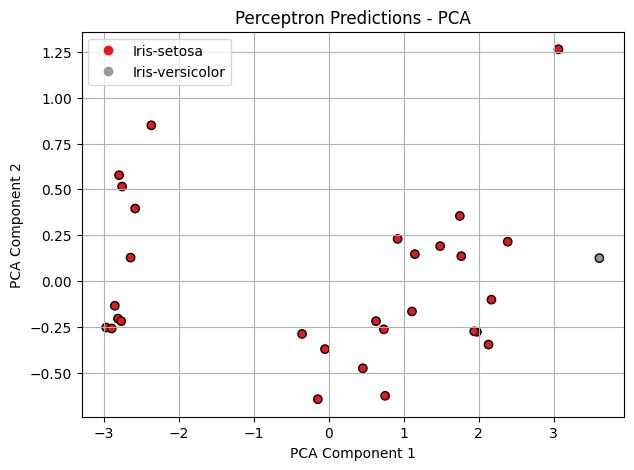

In [19]:
# Perceptron - Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
labels = label_encoder.classes_.astype(str)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='Set1', edgecolor='k')
plt.title("Perceptron Predictions - PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=labels.tolist())
plt.grid(True)
plt.show()

In [20]:
# KNN - Initialize and train
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [21]:
# KNN - Results
accuracy = accuracy_score(y_sepals_test, y_pred)
print(f"KNN accuracy (k=3): {accuracy:.4f}")

KNN accuracy (k=3): 1.0000


In [22]:
# KNN - 5-fold cross-validation
cv_scores = cross_val_score(knn, X, y, cv=5)
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, start=1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nCross Validation Mean Score: {np.mean(cv_scores):.4f}")
print(f"\nStandard Deviation: {np.std(cv_scores):.4f}")

Cross Validation Scores:
  Fold 1: 0.9667
  Fold 2: 0.9667
  Fold 3: 0.9333
  Fold 4: 0.9667
  Fold 5: 1.0000

Cross Validation Mean Score: 0.9667

Standard Deviation: 0.0211


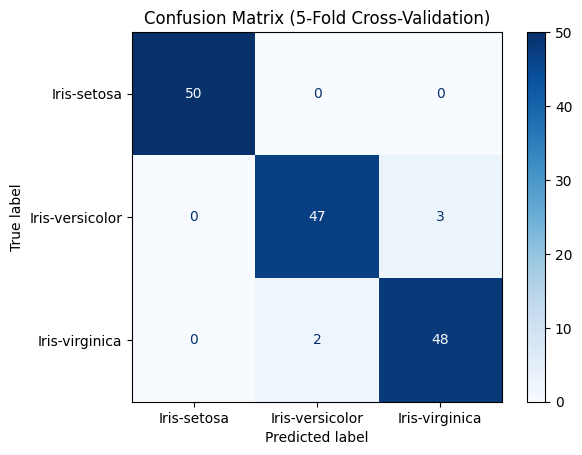

In [23]:
# KNN - 5-fold Confusion Matrix
y_pred_cv = cross_val_predict(knn, X, y, cv=5)
cm_cv = confusion_matrix(y, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=label_encoder.classes_)
disp_cv.plot(cmap='Blues')
plt.title("Confusion Matrix (5-Fold Cross-Validation)")
plt.show()

In [24]:
# Decision Tree - Initialize and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [25]:
# Decision Tree - Results
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.4f}")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_tree, target_names=labels))

Decision Tree Accuracy: 1.0000
Classification Report:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



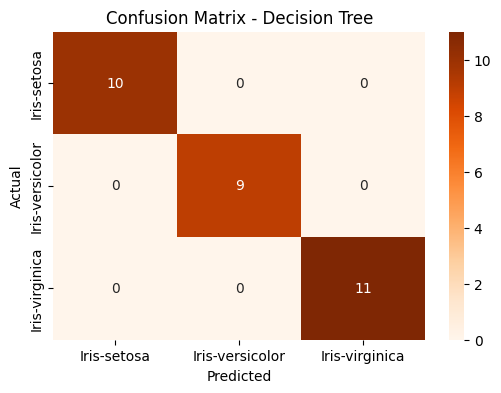

In [26]:
# Decision Tree - Confusion Matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

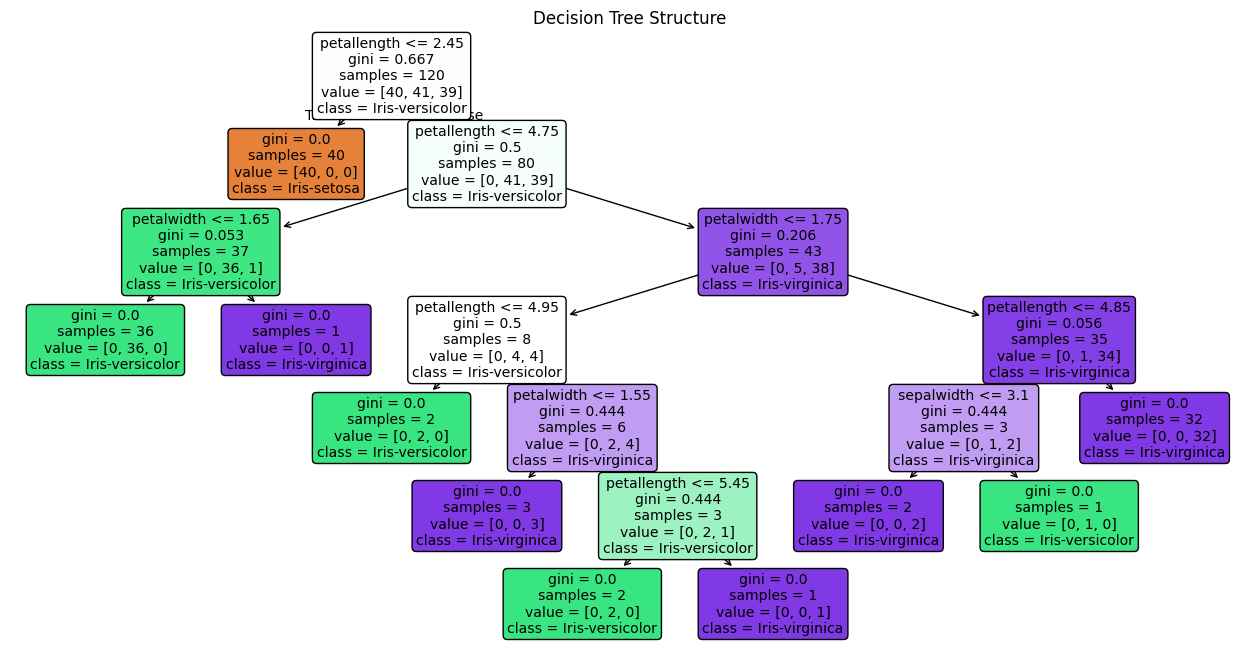

In [27]:
# Decision Tree - Tree Visualization
plt.figure(figsize=(16, 8))
plot_tree(tree, feature_names=X.columns, class_names=labels, filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

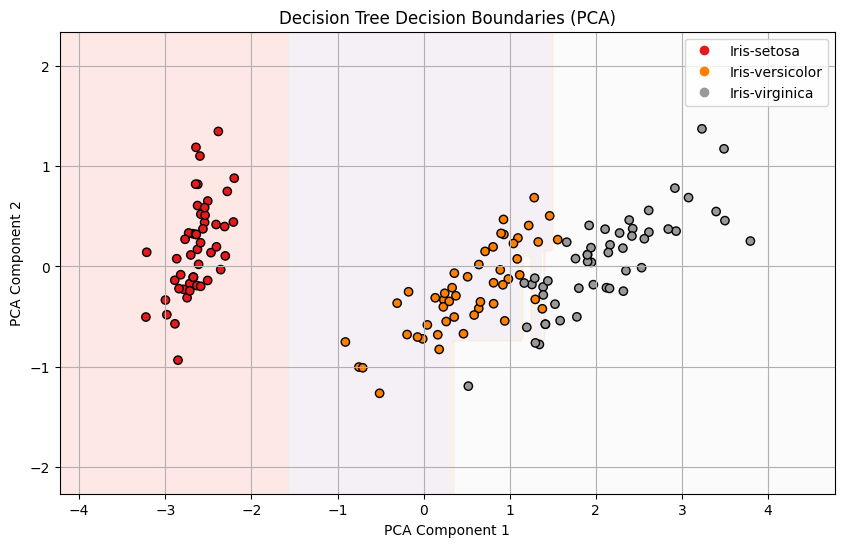

In [28]:
# Decision Tree - PCA Interpretation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

tree_pca = DecisionTreeClassifier(random_state=42)
tree_pca.fit(X_train_pca, y_train_pca)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

Z = tree_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z_numeric = label_encoder.transform(Z) 
Z_numeric = Z_numeric.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap='Pastel1')

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_encoder.transform(y), edgecolor='k', cmap='Set1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Tree Decision Boundaries (PCA)')

handles, _ = scatter.legend_elements()
labels = list(label_encoder.classes_)
plt.legend(handles=handles[:len(labels)], labels=labels[:len(handles)])
plt.grid(True)
plt.show()


In [29]:
# Neural Network - Initialize and train
def neural_network(layers): 
    model = Sequential()
    units = layers[0]
    model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    for units in layers[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    y_train_nn = to_categorical(y_train)
    history = model.fit(X_train, y_train_nn, epochs=30, validation_split=0.2, verbose=1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    y_pred_nn = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_nn, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))   

Epoch 1/30


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3451 - loss: 1.8450 - val_accuracy: 0.2917 - val_loss: 1.4619
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2747 - loss: 1.8736 - val_accuracy: 0.2917 - val_loss: 1.3428
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3880 - loss: 1.5319 - val_accuracy: 0.2917 - val_loss: 1.2495
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3620 - loss: 1.4069 - val_accuracy: 0.3750 - val_loss: 1.1679
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2995 - loss: 1.3831 - val_accuracy: 0.3750 - val_loss: 1.0986
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2357 - loss: 1.3105 - val_accuracy: 0.2500 - val_loss: 1.0458
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2852 - loss: 1.2495 - val_accuracy: 0.3750 - val_loss: 0.9994
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2448 - loss: 1.2279 - val_accuracy: 0.3750 - val_loss: 0.9608
Epoch 9/30

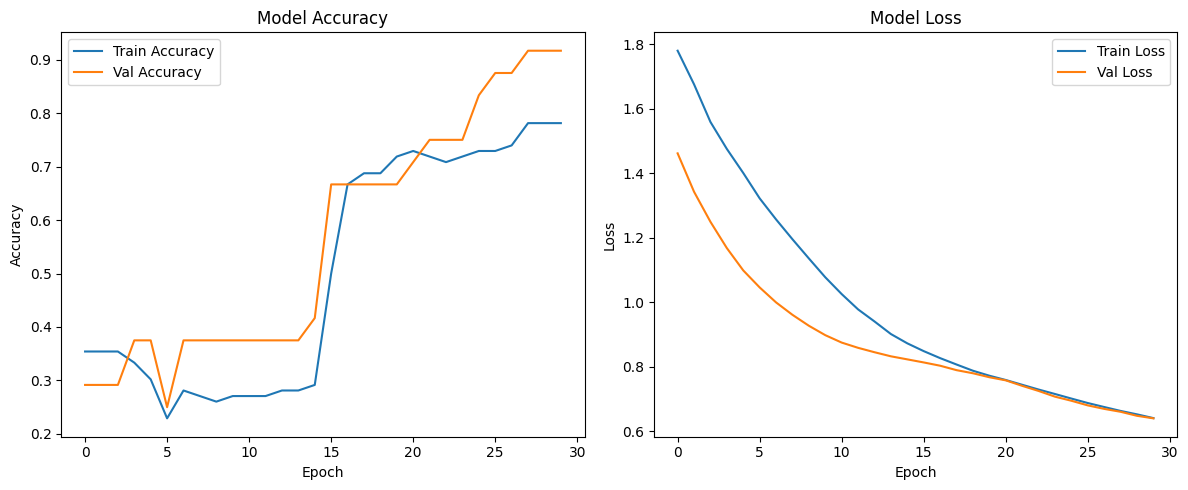

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


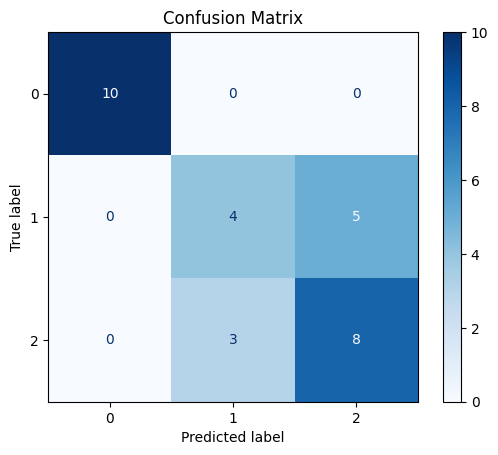

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.57      0.44      0.50         9
           2       0.62      0.73      0.67        11

    accuracy                           0.73        30
   macro avg       0.73      0.72      0.72        30
weighted avg       0.73      0.73      0.73        30



In [30]:
# Neural Network - Training the model
# 1 Layer, 32 units
neural_network([32])

Epoch 1/30


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3073 - loss: 1.7931 - val_accuracy: 0.2083 - val_loss: 1.6918
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4245 - loss: 1.3409 - val_accuracy: 0.2083 - val_loss: 1.4556
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3854 - loss: 1.2500 - val_accuracy: 0.2083 - val_loss: 1.2420
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3542 - loss: 1.1749 - val_accuracy: 0.2083 - val_loss: 1.0739
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4870 - loss: 1.0138 - val_accuracy: 0.7083 - val_loss: 0.9627
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6354 - loss: 0.9656 - val_accuracy: 0.7083 - val_loss: 0.8913
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6589 - loss: 0.8957 - val_accuracy: 0.7083 - val_loss: 0.8465
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6628 - loss: 0.8438 - val_accuracy: 0.7083 - val_loss: 0.8307
Epoch 9/30

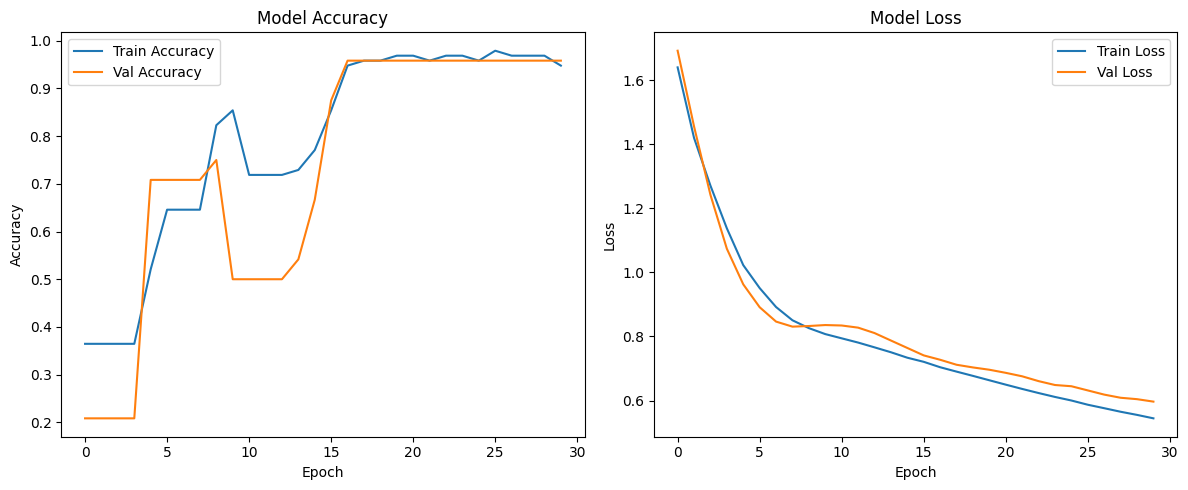

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


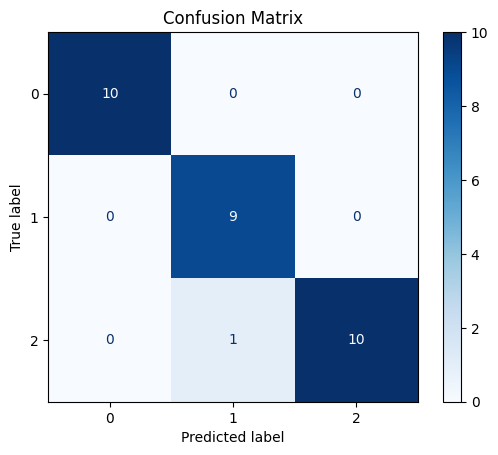

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [31]:
# Neural Network - Training the model
# 2 Layers, 32 and 16 units
neural_network([32, 16])

Epoch 1/30


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.2943 - loss: 1.3240 - val_accuracy: 0.2917 - val_loss: 1.2499
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3919 - loss: 1.0972 - val_accuracy: 0.2917 - val_loss: 1.0887
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3880 - loss: 1.0213 - val_accuracy: 0.5000 - val_loss: 0.9797
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7344 - loss: 0.9516 - val_accuracy: 1.0000 - val_loss: 0.9035
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8737 - loss: 0.9007 - val_accuracy: 0.7917 - val_loss: 0.8487
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6901 - loss: 0.8391 - val_accuracy: 0.7083 - val_loss: 0.7983
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6589 - loss: 0.7932 - val_accuracy: 0.8750 - val_loss: 0.7644
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8372 - loss: 0.7466 - val_accuracy: 1.0000 - val_loss: 0.7336
Epoch 9/30

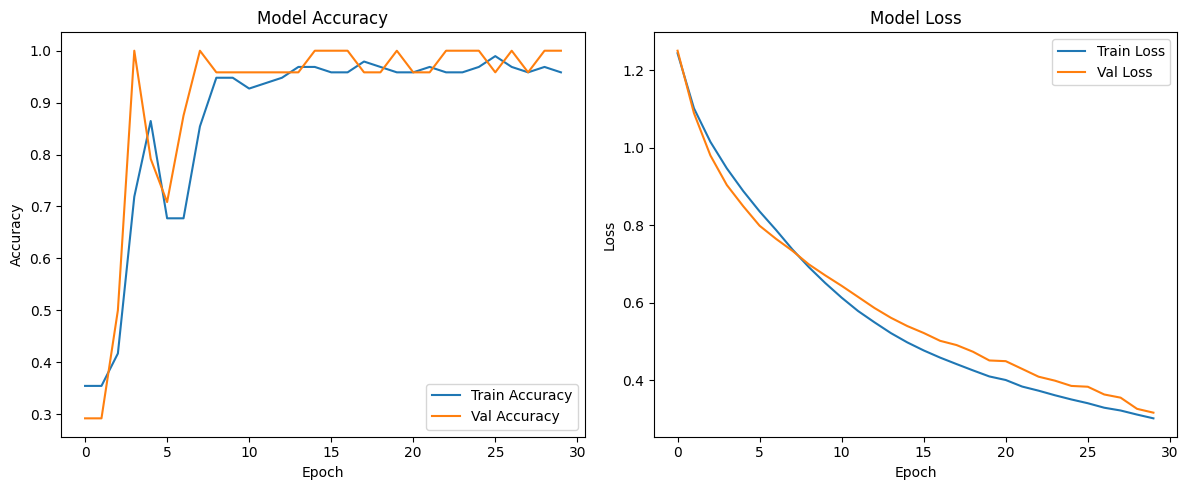

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


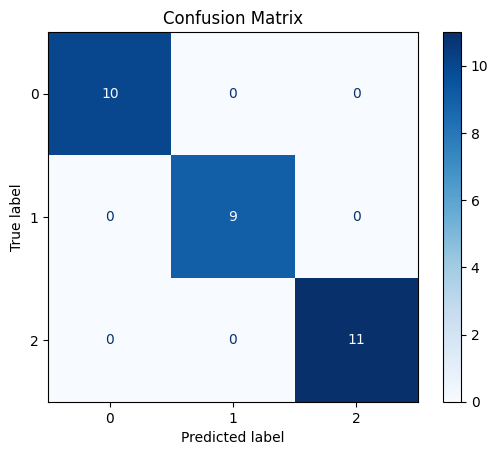

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [32]:
# Neural Network - Training the model
# 2 Layers, 128 and 64 units
neural_network([128, 64])

In [33]:
# Clustering - Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

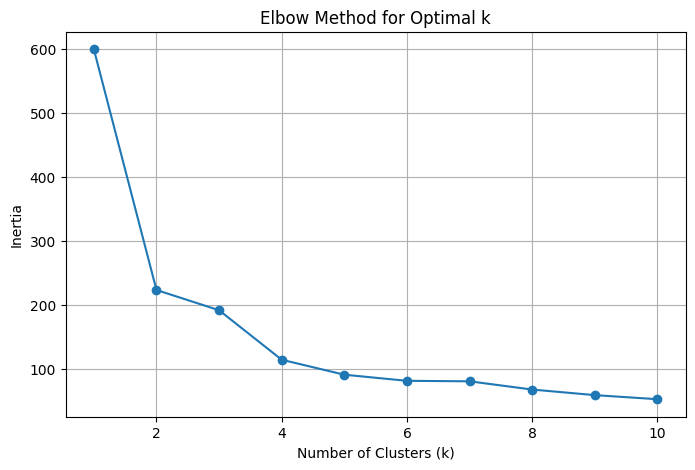

In [34]:
# Clustering - Elbow Method
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

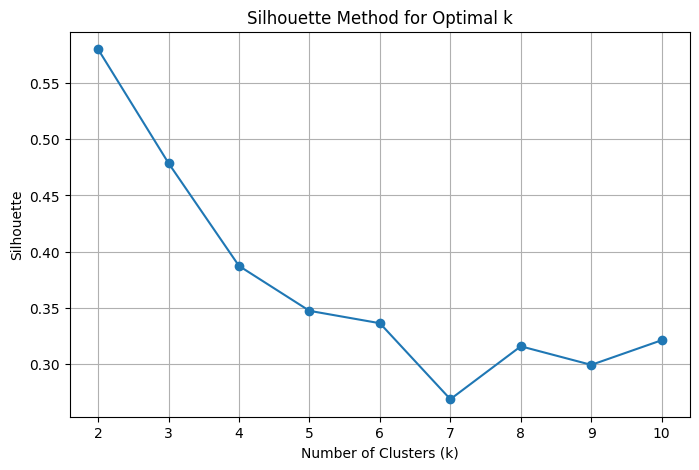

In [35]:
# Clustering - Silhouette Method
silhouettes = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_, metric='euclidean'))

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouettes, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

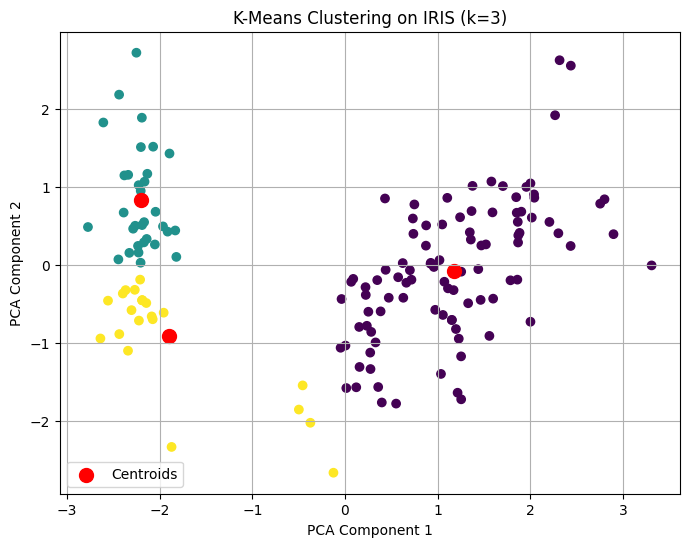

In [36]:
# Clustering - Final Experiment
kmeans_final = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
centers = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='o', label='Centroids')
plt.title('K-Means Clustering on IRIS (k=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

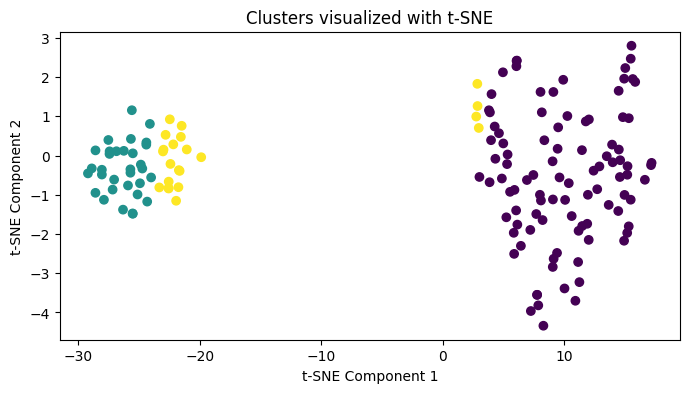

In [37]:
# Clustering - TSNE Interpretation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [38]:
# Clustering - Final Experiment Results
sil_score = silhouette_score(X_scaled, clusters)
db_score = davies_bouldin_score(X_scaled, clusters)
ch_score = calinski_harabasz_score(X_scaled, clusters)
ari_score = adjusted_rand_score(y, clusters)
fmi_score = fowlkes_mallows_score(y, clusters)
wcss = kmeans.inertia_
print(f"Silhouette Score: {sil_score:.4f}\n")
print(f"Davies-Bouldin Index: {db_score:.4f}\n")
print(f"Calinski-Harabasz Index: {ch_score:.4f}\n")
print(f"Adjusted Rand Index: {ari_score:.4f}\n")
print(f"Fowlkes-Mallows Index: {fmi_score:.4f}\n")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}\n")


Silhouette Score: 0.4787

Davies-Bouldin Index: 0.7868

Calinski-Harabasz Index: 156.1430

Adjusted Rand Index: 0.4290

Fowlkes-Mallows Index: 0.6613

Within-Cluster Sum of Squares (WCSS): 52.9900



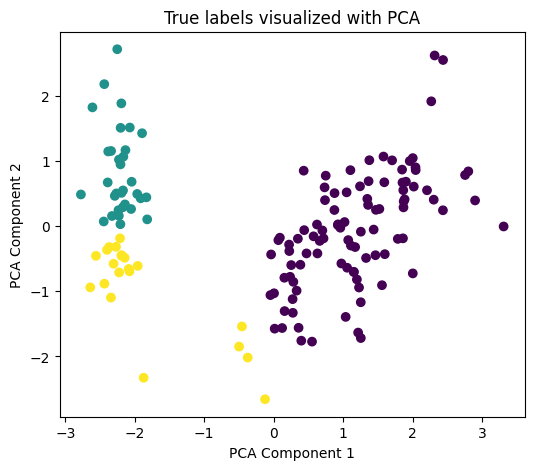

In [39]:
# Clustering - PCA Interpretation
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("True labels visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()